# MLP
Convert CNN_264 to an MLP.

More neurons.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-27 20:15:34.056365


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-27 20:16:09.264586
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65664     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-27 20:16:10.020759
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-27 20:16:31.423759

Training # 1 1
2023-03-27 20:16:31.425271
2023-03-27 20:16:31.425337
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-27 20:16:31.501733


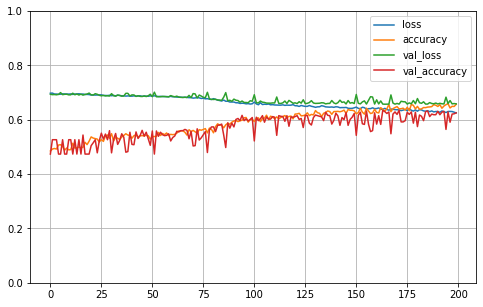


2023-03-27 20:18:55.131541

Testing # 1 1
2023-03-27 20:18:55.131645
2023-03-27 20:18:55.131690
PREDICT
2023-03-27 20:18:55.146408
Test 1:0 458:412 52.64%
Predict 1:0 506:364 58.16%
Test sizes (870, 1025) (870,)
Range of scores: 0.017094947 to 0.9509725
Score threshold 0.5
Confusion matrix
 [[225 187]
 [139 319]]
Normalized matrix
 [[0.25862069 0.21494253]
 [0.15977011 0.36666667]]


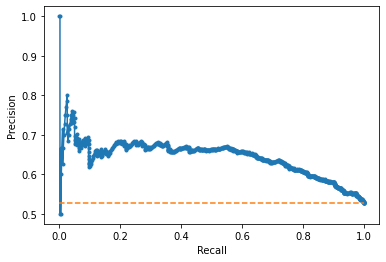

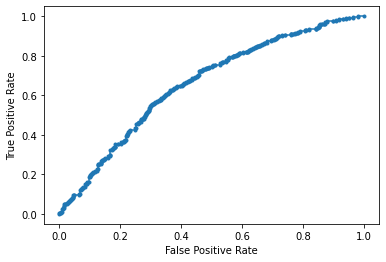

Accuracy: 62.53% Precision: 63.04% Recall: 69.65%
F1: 66.18% MCC: 0.2456
AUPRC: 64.41% AUROC: 65.85%
 accuracy [62.52873563218391]
 precision [63.04347826086957]
 recall [69.65065502183407]
 F1 [66.18257261410788]
 MCC [0.24557687226582792]
 AUPRC [64.406697038502]
 AUROC [65.84718277017001]
2023-03-27 20:18:56.182073

Training # 1 2
2023-03-27 20:18:56.184235
2023-03-27 20:18:56.184625
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-27 20:18:56.266079


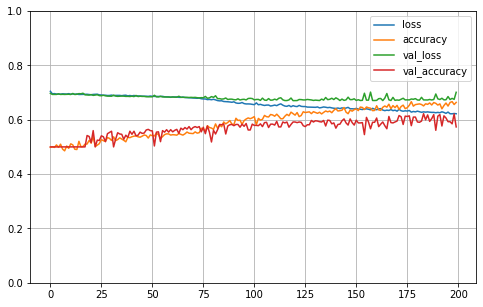


2023-03-27 20:20:34.355426

Testing # 1 2
2023-03-27 20:20:34.355813
2023-03-27 20:20:34.355866
PREDICT
2023-03-27 20:20:34.363233
Test 1:0 442:442 50.00%
Predict 1:0 725:159 82.01%
Test sizes (884, 1025) (884,)
Range of scores: 0.022209728 to 0.9898982
Score threshold 0.5
Confusion matrix
 [[112 330]
 [ 47 395]]
Normalized matrix
 [[0.12669683 0.37330317]
 [0.05316742 0.44683258]]


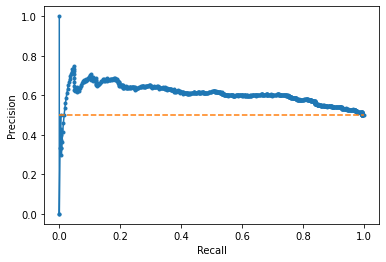

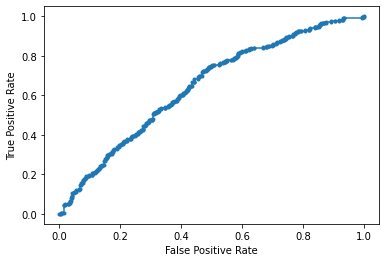

Accuracy: 57.35% Precision: 54.48% Recall: 89.37%
F1: 67.69% MCC: 0.1914
AUPRC: 60.64% AUROC: 64.45%
 accuracy [57.35294117647059]
 precision [54.48275862068965]
 recall [89.36651583710407]
 F1 [67.69494430162811]
 MCC [0.19144577712231142]
 AUPRC [60.6394251871891]
 AUROC [64.44790237710122]
2023-03-27 20:20:35.205841

Training # 1 3
2023-03-27 20:20:35.206125
2023-03-27 20:20:35.206188
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-27 20:20:35.304072


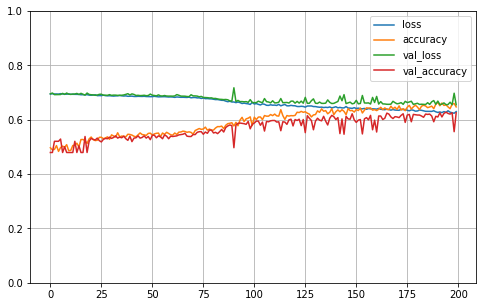


2023-03-27 20:22:11.971442

Testing # 1 3
2023-03-27 20:22:11.971630
2023-03-27 20:22:11.971926
PREDICT
2023-03-27 20:22:11.980908
Test 1:0 442:407 52.06%
Predict 1:0 508:341 59.84%
Test sizes (849, 1025) (849,)
Range of scores: 0.02971644 to 0.95335543
Score threshold 0.5
Confusion matrix
 [[215 192]
 [126 316]]
Normalized matrix
 [[0.2532391  0.22614841]
 [0.14840989 0.37220259]]


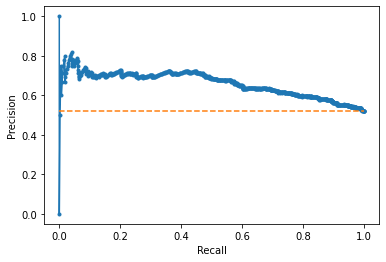

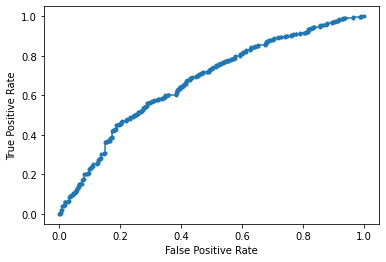

Accuracy: 62.54% Precision: 62.20% Recall: 71.49%
F1: 66.53% MCC: 0.2478
AUPRC: 65.97% AUROC: 67.05%
 accuracy [62.544169611307424]
 precision [62.20472440944882]
 recall [71.49321266968326]
 F1 [66.52631578947368]
 MCC [0.2478225483604767]
 AUPRC [65.96528103926364]
 AUROC [67.0539317598141]
2023-03-27 20:22:13.182061

Training # 1 4
2023-03-27 20:22:13.182881
2023-03-27 20:22:13.182940
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-27 20:22:13.263750


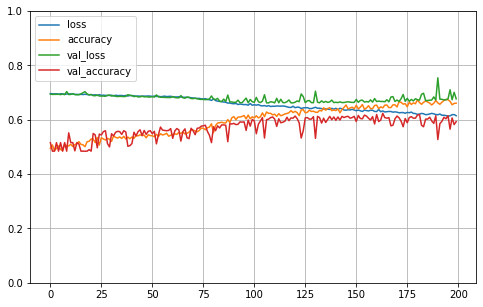


2023-03-27 20:23:50.750709

Testing # 1 4
2023-03-27 20:23:50.750831
2023-03-27 20:23:50.750874
PREDICT
2023-03-27 20:23:50.758126
Test 1:0 459:431 51.57%
Predict 1:0 619:271 69.55%
Test sizes (890, 1025) (890,)
Range of scores: 0.0072836103 to 0.96512246
Score threshold 0.5
Confusion matrix
 [[170 261]
 [101 358]]
Normalized matrix
 [[0.19101124 0.29325843]
 [0.11348315 0.40224719]]


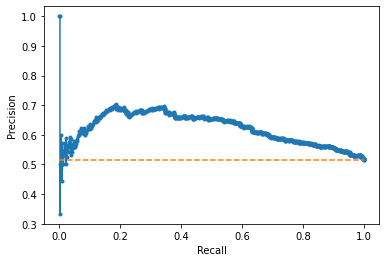

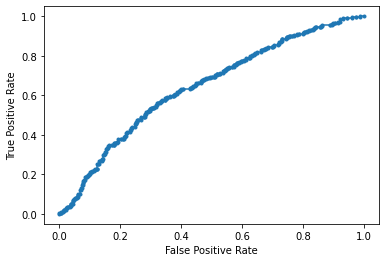

Accuracy: 59.33% Precision: 57.84% Recall: 78.00%
F1: 66.42% MCC: 0.1894
AUPRC: 62.13% AUROC: 64.34%
 accuracy [59.325842696629216]
 precision [57.83521809369952]
 recall [77.99564270152506]
 F1 [66.41929499072357]
 MCC [0.1893788865728422]
 AUPRC [62.13398533171163]
 AUROC [64.34092069413484]
2023-03-27 20:23:51.598048

Training # 1 5
2023-03-27 20:23:51.598991
2023-03-27 20:23:51.599059
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-27 20:23:51.683359


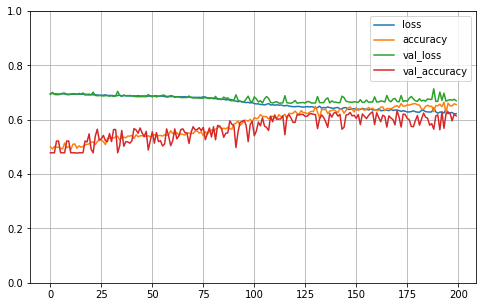


2023-03-27 20:25:32.292338

Testing # 1 5
2023-03-27 20:25:32.297146
2023-03-27 20:25:32.297574
PREDICT
2023-03-27 20:25:32.310401
Test 1:0 457:419 52.17%
Predict 1:0 531:345 60.62%
Test sizes (876, 1025) (876,)
Range of scores: 0.007962564 to 0.96831113
Score threshold 0.5
Confusion matrix
 [[213 206]
 [132 325]]
Normalized matrix
 [[0.24315068 0.23515982]
 [0.15068493 0.37100457]]


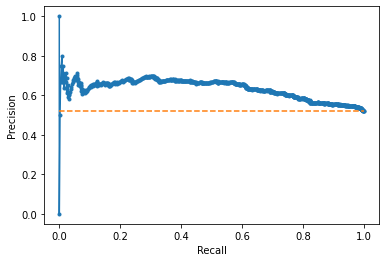

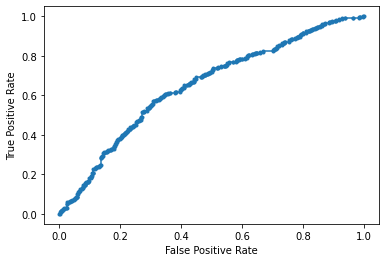

Accuracy: 61.42% Precision: 61.21% Recall: 71.12%
F1: 65.79% MCC: 0.2244
AUPRC: 63.37% AUROC: 64.89%
 accuracy [61.41552511415526]
 precision [61.20527306967985]
 recall [71.11597374179432]
 F1 [65.78947368421053]
 MCC [0.22442357082887487]
 AUPRC [63.36708035429805]
 AUROC [64.89192252053707]
2023-03-27 20:25:33.564069

Training # 2 1
2023-03-27 20:25:33.566411
2023-03-27 20:25:33.566852
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-27 20:25:33.694553


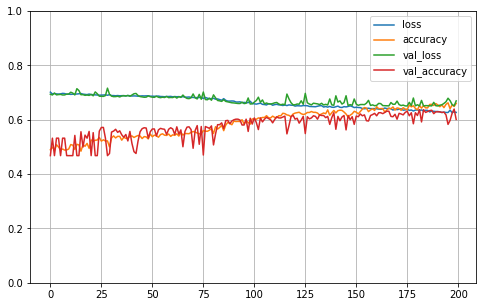


2023-03-27 20:27:57.420557

Testing # 2 1
2023-03-27 20:27:57.420671
2023-03-27 20:27:57.420727
PREDICT
2023-03-27 20:27:57.430705
Test 1:0 472:415 53.21%
Predict 1:0 282:605 31.79%
Test sizes (887, 1025) (887,)
Range of scores: 0.02411954 to 0.9814851
Score threshold 0.5
Confusion matrix
 [[333  82]
 [272 200]]
Normalized matrix
 [[0.37542277 0.09244645]
 [0.30665163 0.22547914]]


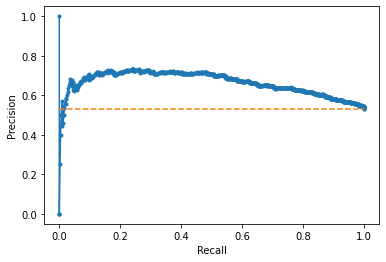

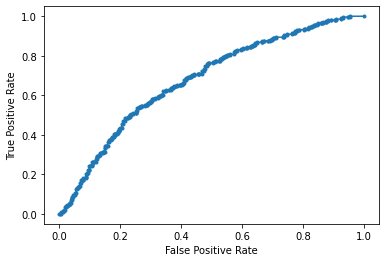

Accuracy: 60.09% Precision: 70.92% Recall: 42.37%
F1: 53.05% MCC: 0.2423
AUPRC: 66.29% AUROC: 67.99%
 accuracy [60.09019165727171]
 precision [70.92198581560284]
 recall [42.3728813559322]
 F1 [53.05039787798409]
 MCC [0.24230770338943952]
 AUPRC [66.28596230523395]
 AUROC [67.98524606902184]
2023-03-27 20:27:58.407855

Training # 2 2
2023-03-27 20:27:58.408968
2023-03-27 20:27:58.409086
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-27 20:27:58.508479


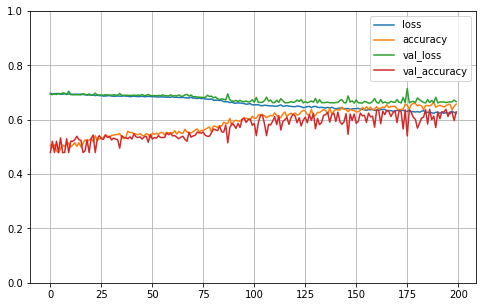


2023-03-27 20:30:21.916968

Testing # 2 2
2023-03-27 20:30:21.917089
2023-03-27 20:30:21.917147
PREDICT
2023-03-27 20:30:21.924657
Test 1:0 452:416 52.07%
Predict 1:0 374:494 43.09%
Test sizes (868, 1025) (868,)
Range of scores: 0.01588114 to 0.9627848
Score threshold 0.5
Confusion matrix
 [[294 122]
 [200 252]]
Normalized matrix
 [[0.33870968 0.140553  ]
 [0.23041475 0.29032258]]


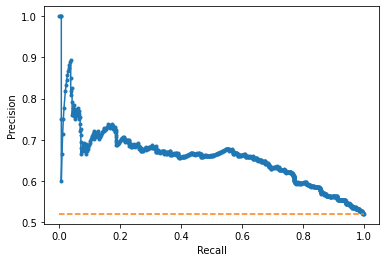

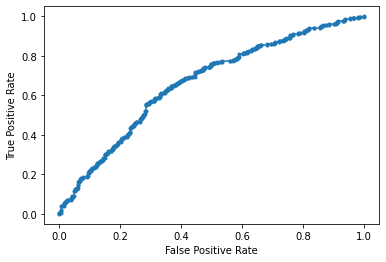

Accuracy: 62.90% Precision: 67.38% Recall: 55.75%
F1: 61.02% MCC: 0.2666
AUPRC: 65.68% AUROC: 66.32%
 accuracy [62.903225806451616]
 precision [67.37967914438502]
 recall [55.75221238938053]
 F1 [61.016949152542374]
 MCC [0.2665853982189967]
 AUPRC [65.68482633940378]
 AUROC [66.32275357385977]
2023-03-27 20:30:22.807861

Training # 2 3
2023-03-27 20:30:22.809089
2023-03-27 20:30:22.809134
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-27 20:30:22.909152


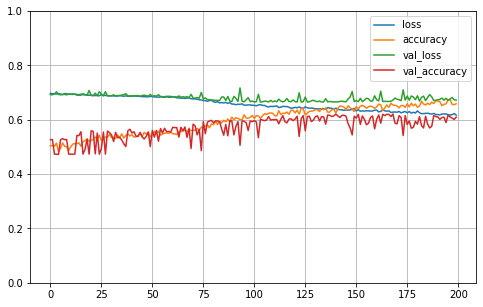


2023-03-27 20:32:09.528833

Testing # 2 3
2023-03-27 20:32:09.530909
2023-03-27 20:32:09.531340
PREDICT
2023-03-27 20:32:09.539787
Test 1:0 453:407 52.67%
Predict 1:0 501:359 58.26%
Test sizes (860, 1025) (860,)
Range of scores: 0.0054184333 to 0.9472265
Score threshold 0.5
Confusion matrix
 [[215 192]
 [144 309]]
Normalized matrix
 [[0.25       0.22325581]
 [0.16744186 0.35930233]]


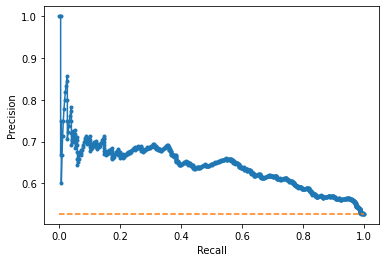

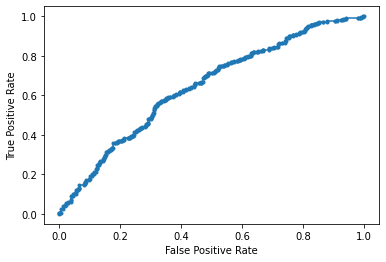

Accuracy: 60.93% Precision: 61.68% Recall: 68.21%
F1: 64.78% MCC: 0.2130
AUPRC: 64.18% AUROC: 64.34%
 accuracy [60.93023255813953]
 precision [61.67664670658682]
 recall [68.21192052980133]
 F1 [64.77987421383648]
 MCC [0.2129971524105304]
 AUPRC [64.17548227000184]
 AUROC [64.34417560245373]
2023-03-27 20:32:10.762307

Training # 2 4
2023-03-27 20:32:10.765265
2023-03-27 20:32:10.765753
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-27 20:32:10.895102


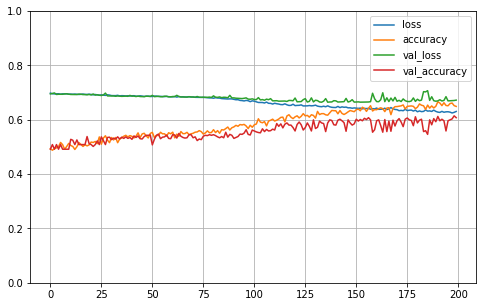


2023-03-27 20:34:35.544270

Testing # 2 4
2023-03-27 20:34:35.544377
2023-03-27 20:34:35.544425
PREDICT
2023-03-27 20:34:35.557799
Test 1:0 432:447 49.15%
Predict 1:0 339:540 38.57%
Test sizes (879, 1025) (879,)
Range of scores: 0.009858514 to 0.91042936
Score threshold 0.5
Confusion matrix
 [[321 126]
 [219 213]]
Normalized matrix
 [[0.36518771 0.14334471]
 [0.24914676 0.24232082]]


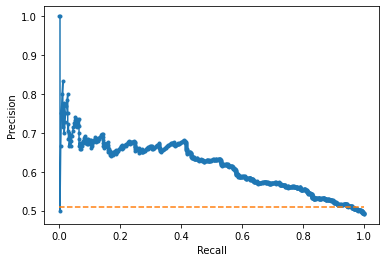

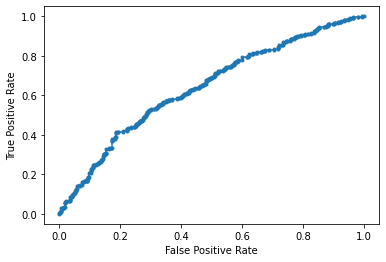

Accuracy: 60.75% Precision: 62.83% Recall: 49.31%
F1: 55.25% MCC: 0.2169
AUPRC: 61.52% AUROC: 64.15%
 accuracy [60.75085324232082]
 precision [62.83185840707964]
 recall [49.30555555555556]
 F1 [55.25291828793774]
 MCC [0.21689233667976834]
 AUPRC [61.524423240254066]
 AUROC [64.1452274422073]
2023-03-27 20:34:36.468232

Training # 2 5
2023-03-27 20:34:36.468522
2023-03-27 20:34:36.468586
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-27 20:34:36.571719


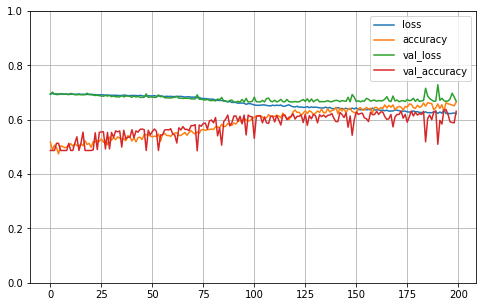


2023-03-27 20:36:19.735734

Testing # 2 5
2023-03-27 20:36:19.735852
2023-03-27 20:36:19.735895
PREDICT
2023-03-27 20:36:19.749526
Test 1:0 449:426 51.31%
Predict 1:0 522:353 59.66%
Test sizes (875, 1025) (875,)
Range of scores: 0.019120231 to 0.97080976
Score threshold 0.5
Confusion matrix
 [[228 198]
 [125 324]]
Normalized matrix
 [[0.26057143 0.22628571]
 [0.14285714 0.37028571]]


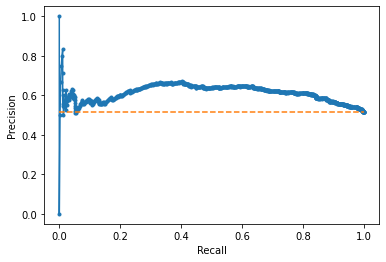

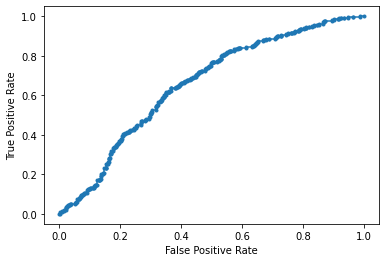

Accuracy: 63.09% Precision: 62.07% Recall: 72.16%
F1: 66.74% MCC: 0.2617
AUPRC: 61.15% AUROC: 65.72%
 accuracy [63.08571428571429]
 precision [62.06896551724138]
 recall [72.16035634743875]
 F1 [66.73532440782698]
 MCC [0.26165284816854406]
 AUPRC [61.14699688700264]
 AUROC [65.71567489569937]
2023-03-27 20:36:20.367693


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 61.09% std 1.82
 precision mean 62.37% std 4.52
 recall mean 66.74% std 13.90
 F1 mean 63.34% std 5.20
 MCC mean 0.23% std 0.03
 AUPRC mean 63.53% std 2.09
 AUROC mean 65.51% std 1.31
 accuracy [[62.52873563218391], [57.35294117647059], [62.544169611307424], [59.325842696629216], [61.41552511415526], [60.09019165727171], [62.903225806451616], [60.93023255813953], [60.75085324232082], [63.08571428571429]]
 precision [[63.04347826086957], [54.48275862068965], [62.20472440944882], [57.83521809369952], [61.20527306967985], [70.92198581560284], [67.37967914438502], [61.67664670658682], [62.83185840707964], [62.06896551724138]]
 recall [[69.65065502183407], [89.36651583710407], [71.49321266968326], [77.99564270152506], [71.11597374179432], [42.3728813559322], [55.75221238938053], [68.21192052980133], [49.30555555555556], [72.16035634743875]]
 F1 [[66.18257261410788], [67.69494430162811], [66.52631578947368], [66.41929499072357], [65.78947368421053], [53.05039787798409], [61.01